In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [2]:
# --- Metrics ---
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Read data

In [3]:
df = pd.read_csv("df_final_bh_amazonas.csv")

In [4]:
df.head()

,Date,DayOfWeek,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,IsDayAfterHoliday,temp_max,temp_min,temp_mean,humidity_max,humidity_min,NUMBER_INT,CO,MP10,O3,MP2.5,SO2
0,2015-01-01,Thu,3,1,1,0,1,0,33.9,20.6,25.912500,89.0,32.0,30,0.0,NaN,68.0,NaN,82.0
1,2015-01-02,Fri,4,1,1,0,0,1,32.9,21.0,26.050000,87.0,38.0,43,0.0,NaN,79.0,NaN,83.0
2,2015-01-03,Sat,5,1,1,1,0,0,33.5,20.2,26.683333,83.0,38.0,23,0.0,NaN,44.0,NaN,83.0
3,2015-01-04,Sun,6,1,1,1,0,0,30.6,22.2,25.641667,81.0,43.0,20,0.0,NaN,49.0,NaN,82.0
4,2015-01-05,Mon,0,2,1,0,0,0,30.8,20.8,25.520833,79.0,36.0,51,0.0,NaN,59.0,NaN,82.0


In [5]:
df.count()

Date                 1826
DayOfWeek            1826
DayOfWeekNum         1826
WeekOfYear           1826
Month                1826
IsWeekend            1826
IsHoliday            1826
IsDayAfterHoliday    1826
temp_max             1826
temp_min             1826
temp_mean            1826
humidity_max         1826
humidity_min         1826
NUMBER_INT           1826
CO                   1581
MP10                 1457
O3                   1265
MP2.5                1195
SO2                  1091
dtype: int64

### Set features

In [6]:
selected_cols_final = [
    'Date',
    'DayOfWeekNum',
    'WeekOfYear',
    'Month',
    'IsWeekend',
    'IsHoliday',
    'NUMBER_INT',
    # 'SO2',
    'temp_max',
    'temp_min',
    'humidity_max',
]

df_final = df[selected_cols_final].copy()

In [7]:
# add lag
# df_final['SO2_lag1'] = df_final['SO2'].shift(1)
# df_final['SO2_lag2'] = df_final['SO2'].shift(2)
# df_final['SO2_lag3'] = df_final['SO2'].shift(3)

df_final['temp_min_lag1'] = df_final['temp_min'].shift(1)
df_final['temp_min_lag2'] = df_final['temp_min'].shift(2)
df_final['temp_min_lag3'] = df_final['temp_min'].shift(3)

# df_final['humidity_max_lag1'] = df_final['humidity_max'].shift(1)
# df_final['humidity_max_lag2'] = df_final['humidity_max'].shift(2)
# df_final['humidity_max_lag3'] = df_final['humidity_max'].shift(3)

In [8]:
df_final = df_final.dropna()

In [9]:
# Check non-null counts and data types
df_final.info()

# Check descriptive statistics
df_final.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
Index: 1823 entries, 3 to 1825
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1823 non-null   object 
 1   DayOfWeekNum   1823 non-null   int64  
 2   WeekOfYear     1823 non-null   int64  
 3   Month          1823 non-null   int64  
 4   IsWeekend      1823 non-null   int64  
 5   IsHoliday      1823 non-null   int64  
 6   NUMBER_INT     1823 non-null   int64  
 7   temp_max       1823 non-null   float64
 8   temp_min       1823 non-null   float64
 9   humidity_max   1823 non-null   float64
 10  temp_min_lag1  1823 non-null   float64
 11  temp_min_lag2  1823 non-null   float64
 12  temp_min_lag3  1823 non-null   float64
dtypes: float64(6), int64(6), object(1)
memory usage: 199.4+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,1823,1823,2019-12-31,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeekNum,1823.0,NaN,NaN,NaN,2.998903,2.00192,0.0,1.0,3.0,5.0,6.0
WeekOfYear,1823.0,NaN,NaN,NaN,26.657707,15.041553,1.0,14.0,27.0,40.0,53.0
Month,1823.0,NaN,NaN,NaN,6.532639,3.445021,1.0,4.0,7.0,10.0,12.0
IsWeekend,1823.0,NaN,NaN,NaN,0.285793,0.451915,0.0,0.0,0.0,1.0,1.0
IsHoliday,1823.0,NaN,NaN,NaN,0.024136,0.153514,0.0,0.0,0.0,0.0,1.0
NUMBER_INT,1823.0,NaN,NaN,NaN,47.806363,15.627747,11.0,37.0,47.0,59.0,94.0
temp_max,1823.0,NaN,NaN,NaN,28.306089,3.039403,17.8,26.3,28.5,30.4,37.7
temp_min,1823.0,NaN,NaN,NaN,17.786725,2.625516,7.3,16.1,18.4,19.7,24.1
humidity_max,1823.0,NaN,NaN,NaN,82.257817,9.232062,42.0,77.0,84.0,90.0,94.0


In [10]:
df_final.dtypes

Date              object
DayOfWeekNum       int64
WeekOfYear         int64
Month              int64
IsWeekend          int64
IsHoliday          int64
NUMBER_INT         int64
temp_max         float64
temp_min         float64
humidity_max     float64
temp_min_lag1    float64
temp_min_lag2    float64
temp_min_lag3    float64
dtype: object

## Train

In [11]:
df_final['Date'] = pd.to_datetime(df_final['Date'])
# df_final = df_final.sort_values(by='Date')

# remove the last 5 days (account for lag ...)
df_final = df_final[:-5]

# Range for training and testing (4 years for training, 1 year for validation)
min_year = df_final['Date'].dt.year.min()
train_mask = df_final['Date'].dt.year < (min_year + 4)
val_mask = df_final['Date'].dt.year == (min_year + 4)



df_train = df_final[train_mask]
df_val = df_final[val_mask]

df_train = df_train.drop(columns=['Date'])
df_val = df_val.drop(columns=['Date'])

X = df_final.drop(columns=['Date', 'NUMBER_INT'])
y = df_final['NUMBER_INT']


X_train = df_train.drop(columns=['NUMBER_INT'])
y_train = df_train['NUMBER_INT']

X_val = df_val.drop(columns=['NUMBER_INT'])
y_val = df_val['NUMBER_INT']

In [12]:
df_train.head()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,temp_max,temp_min,humidity_max,temp_min_lag1,temp_min_lag2,temp_min_lag3
3,6,1,1,1,0,20,30.6,22.2,81.0,20.2,21.0,20.6
4,0,2,1,0,0,51,30.8,20.8,79.0,22.2,20.2,21.0
5,1,2,1,0,0,23,29.5,20.5,79.0,20.8,22.2,20.2
6,2,2,1,0,0,43,28.0,19.9,78.0,20.5,20.8,22.2
7,3,2,1,0,0,49,30.4,19.7,74.0,19.9,20.5,20.8


In [13]:
df_train.tail()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,temp_max,temp_min,humidity_max,temp_min_lag1,temp_min_lag2,temp_min_lag3
1456,3,52,12,0,0,60,24.8,18.8,92.0,18.6,18.5,18.5
1457,4,52,12,0,0,61,25.4,18.5,92.0,18.8,18.6,18.5
1458,5,52,12,1,0,30,27.5,17.7,92.0,18.5,18.8,18.6
1459,6,52,12,1,0,26,27.3,18.5,93.0,17.7,18.5,18.8
1460,0,1,12,0,0,61,25.9,19.2,92.0,18.5,17.7,18.5


In [14]:
df_val.head()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,temp_max,temp_min,humidity_max,temp_min_lag1,temp_min_lag2,temp_min_lag3
1461,1,1,1,0,1,44,27.9,19.2,92.0,19.2,18.5,17.7
1462,2,1,1,0,0,45,31.1,18.9,90.0,19.2,19.2,18.5
1463,3,1,1,0,0,28,30.7,20.4,88.0,18.9,19.2,19.2
1464,4,1,1,0,0,37,25.4,19.0,91.0,20.4,18.9,19.2
1465,5,1,1,1,0,36,30.1,18.6,91.0,19.0,20.4,18.9


In [15]:
df_val.tail()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,temp_max,temp_min,humidity_max,temp_min_lag1,temp_min_lag2,temp_min_lag3
1816,6,51,12,1,0,34,32.9,20.3,84.0,20.0,19.7,19.9
1817,0,52,12,0,0,47,25.9,19.0,91.0,20.3,20.0,19.7
1818,1,52,12,0,0,37,24.6,17.6,91.0,19.0,20.3,20.0
1819,2,52,12,0,1,59,30.3,17.4,91.0,17.6,19.0,20.3
1820,3,52,12,0,0,71,30.4,20.8,79.0,17.4,17.6,19.0


## Test (10x with cv)

In [16]:
results = []
results30 = []

param_grid = {
    'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160],
    'max_depth': [2, 4, 6, 10, 12, 14, 16, 18, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [17]:
for i in range(10):
    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=i),
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print(f"\nRun {i+1} Best Hyperparameters:")
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Best R-squared: {grid_search.best_score_:.4f}")

    best_xgb_model = grid_search.best_estimator_
    y_pred = best_xgb_model.predict(X_val)

    # Metrics 1y
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    mape_val = mape(y_val, y_pred)
    smape_val = smape(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    corr = np.corrcoef(y_val, y_pred)[0, 1]

    # Metrics 30d
    y_pred_30d = best_xgb_model.predict(X_val[:30])
    y_val_30 = y_val[:30]
    mse_30d = mean_squared_error(y_val_30, y_pred_30d)
    rmse_30d = np.sqrt(mse_30d)
    mae_30d = mean_absolute_error(y_val_30, y_pred_30d)
    mape_val_30d = mape(y_val_30, y_pred_30d)
    smape_val_30d = smape(y_val_30, y_pred_30d)
    r2_30d = r2_score(y_val_30, y_pred_30d)
    corr_30d = np.corrcoef(y_val_30, y_pred_30d)[0, 1]

    results.append({
        'run': i+1,
        'random_state': i,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape_val,
        'sMAPE': smape_val,
        'R2': r2,
        'Correlation': corr,
        'Best Params': grid_search.best_params_,
        'Best Cross-validated R-squared': grid_search.best_score_
    })

    results30.append({
        'run': i+1,
        'random_state': i,
        'MSE_30d': mse_30d,
        'RMSE_30d': rmse_30d,
        'MAE_30d': mae_30d,
        'MAPE_30d': mape_val_30d,
        'sMAPE_30d': smape_val_30d,
        'R2_30d': r2_30d,
        'Correlation_30d': corr_30d
    })




Run 1 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}
Best R-squared: 0.5551

Run 2 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}
Best R-squared: 0.5551

Run 3 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}
Best R-squared: 0.5551

Run 4 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}
Best R-squared: 0.5551

Run 5 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}
Best R-squared: 0.5551

Run 6 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_es

### Results 1y

In [18]:
results_df = pd.DataFrame(results)
results_df

,run,random_state,MSE,RMSE,MAE,MAPE,sMAPE,R2,Correlation,Best Params,Best Cross-validated R-squared
0,1,0,122.1931,11.054099,8.282876,15.703462,16.685478,0.488864,0.78261,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.555057
1,2,1,122.1931,11.054099,8.282876,15.703462,16.685478,0.488864,0.78261,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.555057
2,3,2,122.1931,11.054099,8.282876,15.703462,16.685478,0.488864,0.78261,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.555057
3,4,3,122.1931,11.054099,8.282876,15.703462,16.685478,0.488864,0.78261,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.555057
4,5,4,122.1931,11.054099,8.282876,15.703462,16.685478,0.488864,0.78261,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.555057
5,6,5,122.1931,11.054099,8.282876,15.703462,16.685478,0.488864,0.78261,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.555057
6,7,6,122.1931,11.054099,8.282876,15.703462,16.685478,0.488864,0.78261,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.555057
7,8,7,122.1931,11.054099,8.282876,15.703462,16.685478,0.488864,0.78261,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.555057
8,9,8,122.1931,11.054099,8.282876,15.703462,16.685478,0.488864,0.78261,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.555057
9,10,9,122.1931,11.054099,8.282876,15.703462,16.685478,0.488864,0.78261,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.555057


In [19]:
results_df.describe()

,run,random_state,MSE,RMSE,MAE,MAPE,sMAPE,R2,Correlation,Best Cross-validated R-squared
count,10.00000,10.00000,10.0000,1.000000e+01,10.000000,1.000000e+01,1.000000e+01,10.000000,10.00000,10.000000
mean,5.50000,4.50000,122.1931,1.105410e+01,8.282876,1.570346e+01,1.668548e+01,0.488864,0.78261,0.555057
std,3.02765,3.02765,0.0000,1.872445e-15,0.000000,1.872445e-15,3.744889e-15,0.000000,0.00000,0.000000
min,1.00000,0.00000,122.1931,1.105410e+01,8.282876,1.570346e+01,1.668548e+01,0.488864,0.78261,0.555057
25%,3.25000,2.25000,122.1931,1.105410e+01,8.282876,1.570346e+01,1.668548e+01,0.488864,0.78261,0.555057
50%,5.50000,4.50000,122.1931,1.105410e+01,8.282876,1.570346e+01,1.668548e+01,0.488864,0.78261,0.555057
75%,7.75000,6.75000,122.1931,1.105410e+01,8.282876,1.570346e+01,1.668548e+01,0.488864,0.78261,0.555057
max,10.00000,9.00000,122.1931,1.105410e+01,8.282876,1.570346e+01,1.668548e+01,0.488864,0.78261,0.555057


### results 30d

In [20]:
results_df_30 = pd.DataFrame(results30)
results_df_30

,run,random_state,MSE_30d,RMSE_30d,MAE_30d,MAPE_30d,sMAPE_30d,R2_30d,Correlation_30d
0,1,0,57.31625,7.57075,6.456023,16.628034,17.801327,0.14398,0.677327
1,2,1,57.31625,7.57075,6.456023,16.628034,17.801327,0.14398,0.677327
2,3,2,57.31625,7.57075,6.456023,16.628034,17.801327,0.14398,0.677327
3,4,3,57.31625,7.57075,6.456023,16.628034,17.801327,0.14398,0.677327
4,5,4,57.31625,7.57075,6.456023,16.628034,17.801327,0.14398,0.677327
5,6,5,57.31625,7.57075,6.456023,16.628034,17.801327,0.14398,0.677327
6,7,6,57.31625,7.57075,6.456023,16.628034,17.801327,0.14398,0.677327
7,8,7,57.31625,7.57075,6.456023,16.628034,17.801327,0.14398,0.677327
8,9,8,57.31625,7.57075,6.456023,16.628034,17.801327,0.14398,0.677327
9,10,9,57.31625,7.57075,6.456023,16.628034,17.801327,0.14398,0.677327


In [21]:
results_df_30.describe()

,run,random_state,MSE_30d,RMSE_30d,MAE_30d,MAPE_30d,sMAPE_30d,R2_30d,Correlation_30d
count,10.00000,10.00000,10.00000,10.00000,10.000000,1.000000e+01,10.000000,10.00000,1.000000e+01
mean,5.50000,4.50000,57.31625,7.57075,6.456023,1.662803e+01,17.801327,0.14398,6.773270e-01
std,3.02765,3.02765,0.00000,0.00000,0.000000,3.744889e-15,0.000000,0.00000,1.170278e-16
min,1.00000,0.00000,57.31625,7.57075,6.456023,1.662803e+01,17.801327,0.14398,6.773270e-01
25%,3.25000,2.25000,57.31625,7.57075,6.456023,1.662803e+01,17.801327,0.14398,6.773270e-01
50%,5.50000,4.50000,57.31625,7.57075,6.456023,1.662803e+01,17.801327,0.14398,6.773270e-01
75%,7.75000,6.75000,57.31625,7.57075,6.456023,1.662803e+01,17.801327,0.14398,6.773270e-01
max,10.00000,9.00000,57.31625,7.57075,6.456023,1.662803e+01,17.801327,0.14398,6.773270e-01


## Plots    

In [22]:
best_idx = results_df['RMSE'].idxmin()
print(f"Best run based on RMSE: Run {results_df.loc[best_idx, 'run']} with RMSE = {results_df.loc[best_idx, 'RMSE']:.2f}")

best_params = results_df.loc[best_idx, 'Best Params']
print(f"Best parameters: {best_params}")

best_random_state = results_df.loc[best_idx, 'run'] - 1 

# Rebuild the best model
best_model = XGBRegressor(random_state=best_random_state, **best_params)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_val)


Best run based on RMSE: Run 1 with RMSE = 11.05
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}


### 1y

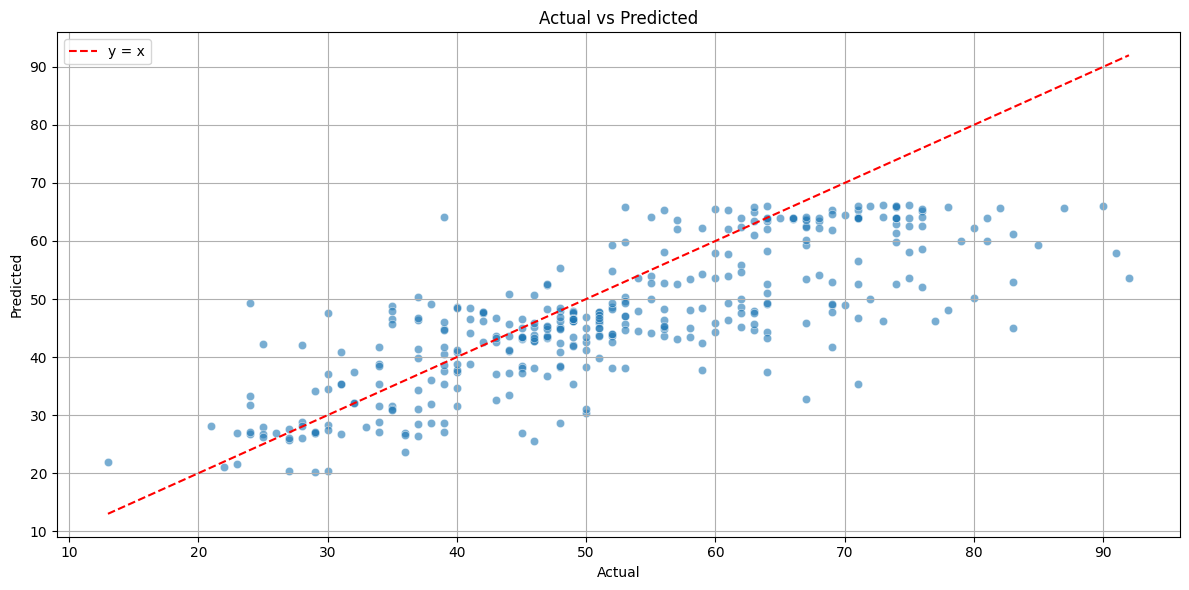

In [23]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val[:], y=y_pred_best, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

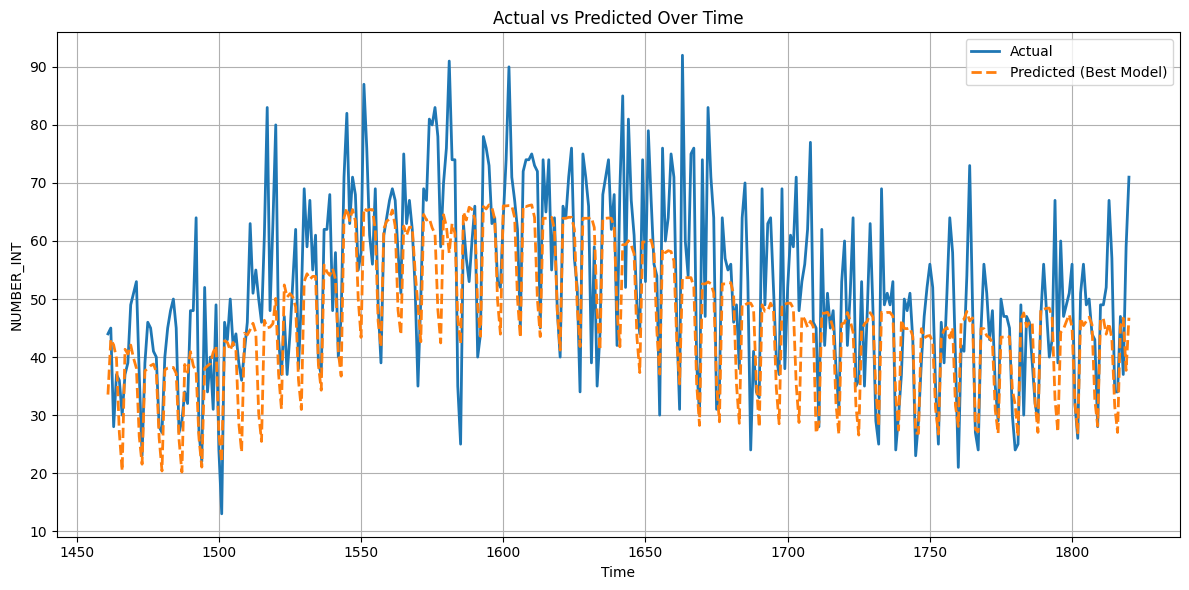

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
plt.plot(y_val.index, y_pred_best, label='Predicted (Best Model)', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title(f'Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 30d

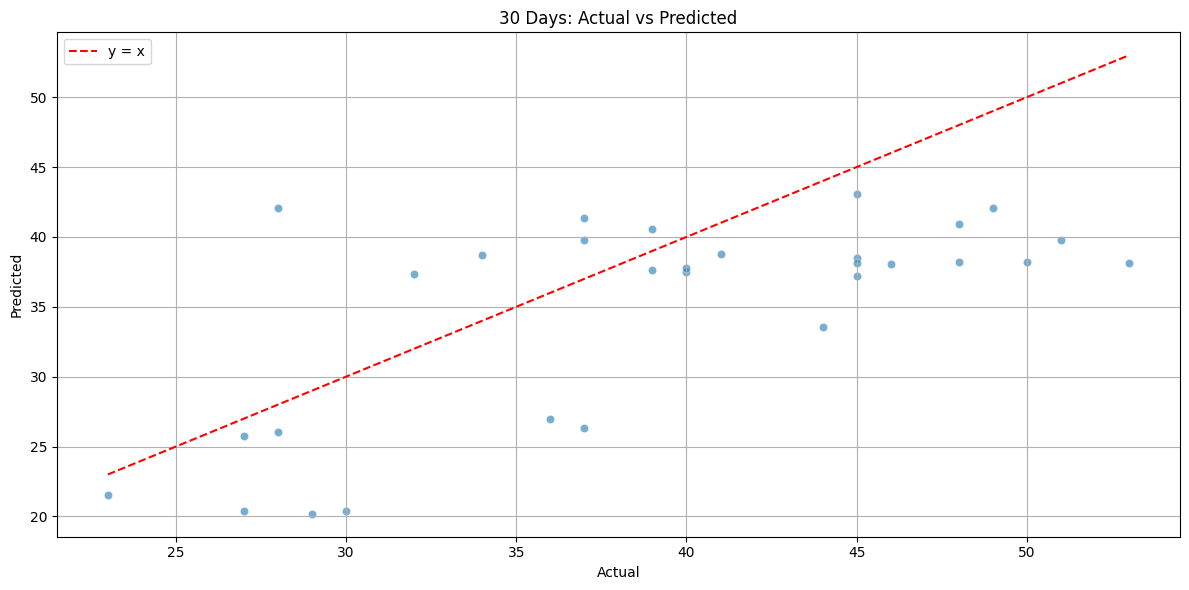

In [25]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val[:30], y=y_pred_best[:30], alpha=0.6)
plt.plot([y_val[:30].min(), y_val[:30].max()], [y_val[:30].min(), y_val[:30].max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('30 Days: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


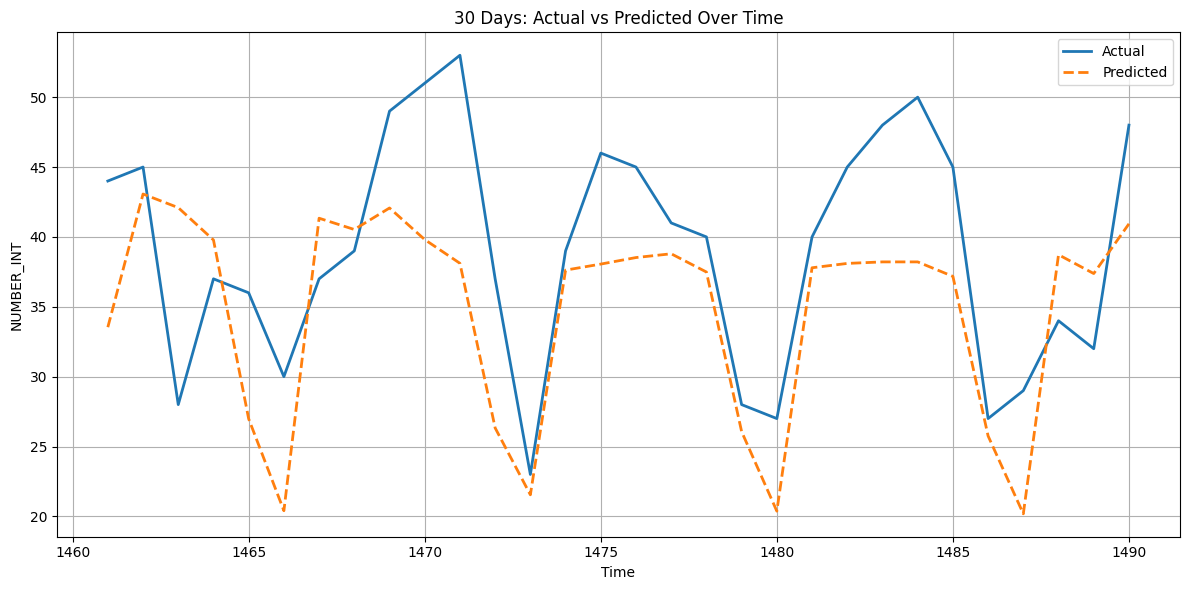

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index[:30], y_val[:30].values, label='Actual', linewidth=2)
plt.plot(y_val.index[:30], y_pred_best[:30], label='Predicted', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title('30 Days: Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

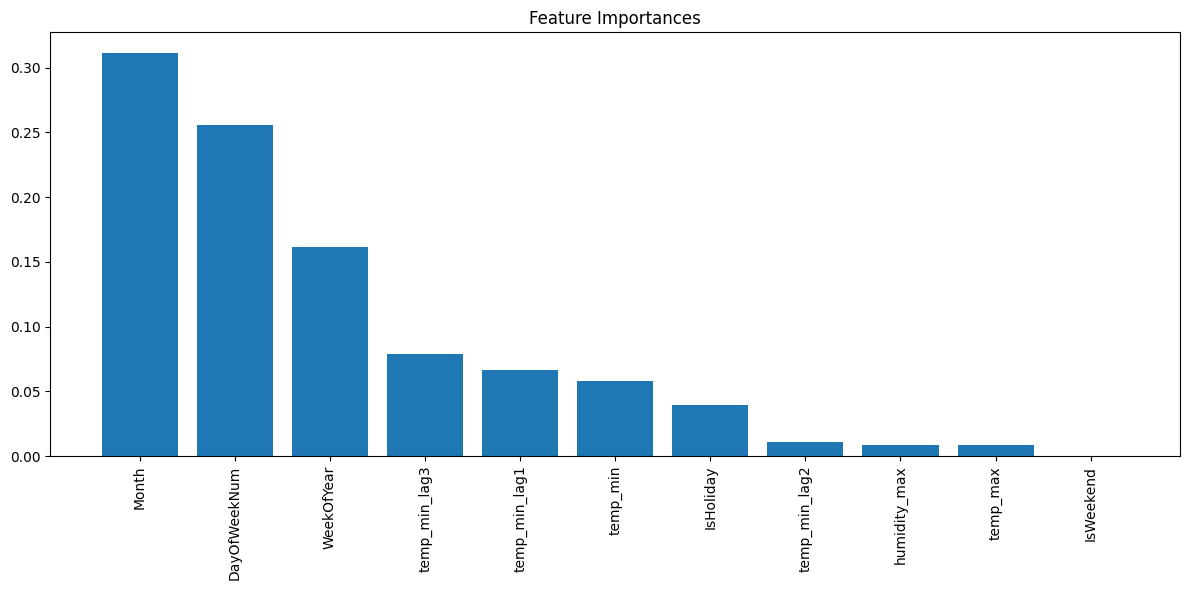

In [27]:
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()